In [2]:
from __future__ import absolute_import
from __future__ import print_function

import time
import os
import numpy as np
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
import tensorflow_probability as tfp
import pickle
import tensorflow as tf
print("tensorflow version: ", tf.__version__)


2024-01-26 17:46:19.936810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow version:  2.15.0


In [5]:
import numpy as np
60000/16

3750.0

/var/folders/j8/bz1_7fld76n736cb57d9dwl00000gn/T/ipykernel_64938/680014799.py:9: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



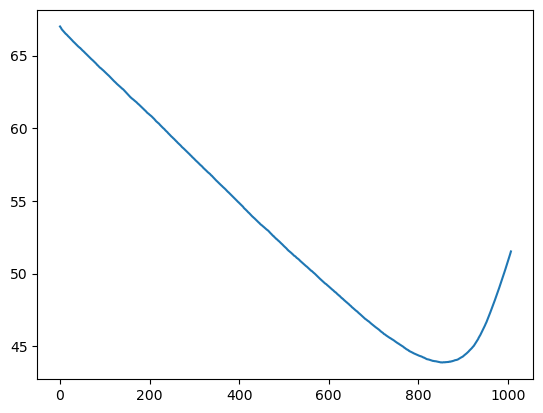

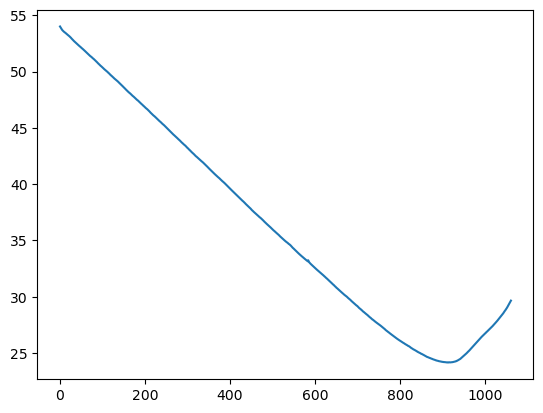

FileNotFoundError: [Errno 2] No such file or directory: 'Data/cells/b3c2.pkl'

In [31]:
import pickle
from pykalman import KalmanFilter


# Load the data
for i in range(8):
    cell_data = pickle.load(open(f"Data/cells/b3c{i}.pkl", "rb"))
    policy_data = cell_data['policy']
    SoC_init = np.float(policy_data.split('(')[1].split(')')[0][:-1])

    summary_data = cell_data['summary']
    Q_remaining = summary_data['QCharge'] - summary_data['QDischarge']
    Q_max = 1.1  # 1.1 Ah is the nominal capacity
    SoC = []
    for i in range(len(Q_remaining)):
        SoC.append(SoC_init)
        SoC_init = SoC_init + (Q_remaining[i]/Q_max)*100.
    # SoC = SoC_init + (Q_remaining/Q_max)*100.

    plt.plot(SoC)
    plt.show()


In [2]:
import numpy as np

a = [5]*10
a

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from Utils.ExtractData import runExtraction
from Utils.PrepareData import runPrepareData
from NeuralNetwork.NN import loadModel
from tensorflow.keras import Model
from NeuralNetwork.ODENN import ode_fn, create_neural_ode_model
import sys
from tqdm.keras import TqdmCallback
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm  # Import tqdm for the progress bar



# ============================== Parameters ==============================
# 2159 cycles: dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'discharge_dQdV', 't'])
# Keys of summary: dict_keys(['IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle'])
# Data keys: ['IR' 'Tavg' 'Tmax' 'Tmin' 'chargetime' 'QCharge' 'QDischarge' 'cycle'] + Qinitial # cycle is in raw form
# Label keys: ['QCharge', 'QDischarge', 'cycle'] # cycle is converted to SOH

# ============================== Secondary testing data ==============================
# ['b3c0.pkl' 'b3c1.pkl' 'b3c3.pkl' 'b3c4.pkl' 'b3c5.pkl' 'b3c6.pkl'
#  'b3c7.pkl' 'b3c8.pkl' 'b3c9.pkl' 'b3c10.pkl' 'b3c11.pkl' 'b3c12.pkl'
#  'b3c13.pkl' 'b3c14.pkl' 'b3c15.pkl' 'b3c16.pkl' 'b3c17.pkl' 'b3c18.pkl'
#  'b3c19.pkl' 'b3c20.pkl' 'b3c21.pkl' 'b3c22.pkl' 'b3c24.pkl' 'b3c25.pkl'
#  'b3c26.pkl' 'b3c27.pkl' 'b3c28.pkl' 'b3c29.pkl' 'b3c30.pkl' 'b3c31.pkl'
#  'b3c33.pkl' 'b3c34.pkl' 'b3c35.pkl' 'b3c36.pkl' 'b3c38.pkl' 'b3c39.pkl'
#  'b3c40.pkl' 'b3c41.pkl' 'b3c44.pkl' 'b3c45.pkl']

# SOC = ((QCharge - QDischarge)/QCharge)*100
# SOH = 1 - cycle

dataDir = './Data'
cellDataDir = './Data/cells'
weightsDir_ML = './Weights/model_1.h5'
weightsDir_ODE = './Weights/model_ODE.h5'
SOC_resultsDir = './Images/SOC_SOH_results/SOC/'
SOH_resultsDir = './Images/SOC_SOH_results/SOH/'
input_keys = ['IR', 'Tavg', 'Tmax', 'Tmin', 'chargetime']
history_input_keys = ['QCharge', 'QDischarge', 'cycle']
output_keys = ['QCharge', 'QDischarge', 'cycle']
num_his = 1 
inputLength = 9
epochs = 40
batch_size = 16
SOH_output_shape = 1 
SOC_output_shape = 1
initial_time = 0.0
lambda_ = 0.3 # should be in (0.01, 0.4)
solution_times = np.array([1.0])
testMode = True
trainMode = True
modelType = 'ODE' # ML, ODE


# ============================== Data preparation ==============================
if (os.listdir('./Data/cells')==[]):
    runExtraction(dataDir)
    print("\n" + "-"*20 + "Step 1: Extract data to cell data" + "-"*20 + "\n")

print("\n" + "-"*20 + "Step 2: Data preparation" + "-"*20 + "\n")
x_train, y_train, train_idx, initial_SOC_train, x_test, y_test, test_idx, initial_SOC_test, x_secondary_test, y_secondary_test, secondary_test_idx, initial_SOC_secondary_test = runPrepareData(cellDataDir, input_keys, history_input_keys, output_keys, num_his)



2024-01-27 03:02:17.118636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mac/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(



--------------------Step 2: Data preparation--------------------

Number of cells in testing set: 43

Number of cells in training set: 41

Number of cells in validation set: 40

2159 cycles: dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'discharge_dQdV', 't'])

Keys of summary: dict_keys(['IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle'])

Train set: 
Data shape: (26552, 8, 1)
Data keys: ['IR' 'Tavg' 'Tmax' 'Tmin' 'chargetime' 'QCharge' 'QDischarge' 'cycle']
Label shape: (26552, 3)
Label keys: ['QCharge', 'QDischarge', 'cycle']


Test set: 
Data shape: (30233, 8, 1)
Data keys: ['IR' 'Tavg' 'Tmax' 'Tmin' 'chargetime' 'QCharge' 'QDischarge' 'cycle']
Label shape: (30233, 3)
Label keys: ['QCharge', 'QDischarge', 'cycle']


Secondary test set: 
Data shape: (41160, 8, 1)
Data keys: ['IR' 'Tavg' 'Tmax' 'Tmin' 'chargetime' 'QCharge' 'QDischarge' 'cycle']
Label shape: (41160, 3)
Label keys: ['QCharge', 'QDischarge', 'cycle']



/Users/mac/anaconda3/lib/python3.11/site-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [6]:
def CreateSOC(capacity_data, initial_SOC_list, idx_length, total_capacity=1.1): # scaled in (0, 1)
    SOC = []
    start = 0
    initial_SOC = 0.
    for idx, initial_SOC in enumerate(initial_SOC_list):
        
        length = idx_length[idx]
        charge = capacity_data[:, 0][start: start+length]
        discharge = capacity_data[:, 1][start: start+length]
        start += length

        for i in range(len(discharge)):
            SOC.append(initial_SOC)
            initial_SOC += ((charge[i]-discharge[i])/total_capacity)*100.

    return np.expand_dims(np.array(SOC)/100., -1)

def ScaleCycle(cycleData, idx_length):
    start = 0
    scaledData = []
    for i in idx_length:
        eachData = cycleData[start: start+i]
        cycle_min = np.min(eachData)
        cycle_max = np.max(eachData)
        scaledData.append((eachData - cycle_min) / (cycle_max - cycle_min))
        start += i
    return np.concatenate((scaledData), axis=0)



# train + test dataset
initial_SOC_train_test = np.concatenate((initial_SOC_train, initial_SOC_test), 0)
train_test_idx = np.concatenate((train_idx, test_idx), 0)
x_train_test = Add_Qinitial(np.concatenate((x_train, x_test)), initial_SOC_train_test, train_test_idx) 
y_train_test = np.concatenate((y_train, y_test))

y_train_test_capacity = y_train_test[:, :2]
y_train_test_SOC = CreateSOC(y_train_test_capacity, initial_SOC_train_test, train_test_idx)
y_train_test_SOC = np.minimum(1, np.maximum(0, y_train_test_SOC))

y_train_test_cycle = ScaleCycle(y_train_test[:, 2], train_test_idx)
y_train_test_SOH = np.expand_dims(1. - y_train_test_cycle, -1)
y_train_test_SOH_SOC = np.concatenate((y_train_test_SOH, y_train_test_SOC), axis=1)

# secondary test dataset
x_secondary_test = Add_Qinitial(x_secondary_test, initial_SOC_secondary_test, secondary_test_idx) 

y_secondary_test_capacity = y_secondary_test[:, :2]
y_secondary_test_SOC = CreateSOC(y_secondary_test_capacity, initial_SOC_secondary_test, secondary_test_idx)
y_secondary_test_SOC = np.minimum(1, np.maximum(0, y_secondary_test_SOC))

y_secondary_test_cycle = ScaleCycle(y_secondary_test[:, 2], secondary_test_idx)
y_secondary_test_SOH = np.expand_dims(1. - y_secondary_test_cycle, -1)

(56785, 8, 1)
(41160, 8, 1)
